In [1]:
knitr::opts_chunk$set(echo = TRUE)

# GMC Walkthrough

In this notebook, I'll walk through our motivation for using Generalized Measures of Correlation (GMC) in measuring the causal relationships between lexical properties of frequency, semantic diversity, and network centrality. We'll examine the intuitive relationship to Pearson's r, and the GMC calculation in depth.

### Setup

In [ ]:
library(panelvar)
library(plm)
library(glue)
library(ggplot2)
library(tseries)
library(tidyr)
library(urca)
library(vars)
library(aod)
library(zoo)
library(panelvar)
library(dplyr)
source('gmc_src/GMC.R')
source('gmc_src/Equality.R')


In [4]:
centrality_measures = c('betweenness', 'closeness', 'clusterrank',
    'constraint', 'degree', 'diffusion','dmnc',
    'hubs', 'laplacian', 'lobby', 'mnc',
    'pagerank', 'topocoefficient', 'transitivity')

frequency_measures = c('zipf')


sd_measures = c('spectral_diversity', 'nonzero_eigenvalues', 'entropy', 'condition_number')

antonyms_df = read.csv("gmc_src/data/antonyms_with_network_properties.csv")
metrics_df = read.csv("gmc_src/data/words_metrics_long_df.csv")

set.seed(42)  # Set seed for reproducibility
#jitter_amount <- runif(nrow(metrics_df), min = -0.05, max = 0.05)
#metrics_df$nonzero_eigenvalues <- metrics_df$nonzero_eigenvalues + jitter_amount




random_word_order <- metrics_df %>%
  distinct(word) %>%
  mutate(rand = runif(n())) %>%
  arrange(rand) %>%
  dplyr::select(word)

# 3. Join this random order back to 'metrics_df' and arrange by 'rand'
metrics_df_random <- metrics_df %>%
  inner_join(random_word_order %>% mutate(rand_order = row_number()), by = "word") %>%
  arrange(rand_order) %>%
  dplyr::select(-rand_order)

metrics_df$random_measure <- runif(nrow(metrics_df), min = 0, max = 1)

# Now 'metrics_df_random' has all rows for each word in a single, consistent random position

# ---- If you need a quick check:
head(metrics_df_random)

# 4. Create decade-based column dictionaries for original vs. randomized data
unique_decades <- unique(metrics_df$decade)
column_dicts_set <- list()

for (decade in unique_decades) {
  subset_df <- metrics_df[metrics_df$decade == decade, ]
  column_dict <- lapply(subset_df, as.list)
  names(column_dict) <- names(subset_df)
  column_dicts_set[[paste0("column_dict_", decade)]] <- column_dict
}

unique_decades_random <- unique(metrics_df_random$decade)
column_dicts_random_set <- list()

for (decade in unique_decades_random) {
  subset_df_random <- metrics_df_random[metrics_df_random$decade == decade, ]
  column_dict_random <- lapply(subset_df_random, as.list)
  names(column_dict_random) <- names(subset_df_random)
  column_dicts_random_set[[paste0("column_dict_", decade)]] <- column_dict_random
}

,word,decade,betweenness,closeness,clusterrank,constraint,degree,diffusion,dmnc,hubs,⋯,lobby,mnc,pagerank,topocoefficient,transitivity,zipf,spectral_diversity,nonzero_eigenvalues,entropy,condition_number
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,unfair,1820,0.000000e+00,0.3639409,253706.0,0.007618547,0.01231195,696536,2.834837,0.06114187,⋯,170,169,2.138588e-05,0.08573144,0.3643280,3.488814,32.74990,8,0.9711643,12.432673
2,unfair,1830,1.499128e-07,0.3813037,317123.4,0.003733816,0.02785141,1262140,2.641080,0.10894379,⋯,376,393,3.971524e-05,0.06105001,0.2513372,3.603549,23.67659,1,0.7179758,8.117734
3,unfair,1840,1.016882e-08,0.3775107,265778.0,0.005255401,0.01839638,917628,2.700407,0.07067368,⋯,256,258,2.474348e-05,0.06994123,0.2897174,3.541916,33.83945,8,1.0297058,9.949971
4,unfair,1850,9.907849e-08,0.3874331,339304.8,0.003965529,0.02428209,1270010,2.642094,0.08893477,⋯,340,345,2.652909e-05,0.06990127,0.2672396,3.578424,34.12160,8,1.1750026,10.769073
5,unfair,1860,5.371908e-08,0.3870199,309139.7,0.004490339,0.02180294,1111082,2.609272,0.08661712,⋯,309,311,2.568552e-05,0.06798322,0.2783114,3.686966,32.08530,6,0.9219049,11.853761
6,unfair,1870,3.808345e-07,0.3884816,339477.2,0.003697384,0.02686940,1311792,2.542953,0.09779340,⋯,383,386,2.747297e-05,0.06368256,0.2588655,3.795260,43.97454,7,1.2599971,16.157654


## 1. General Overview

We want to examine the causal relationships between general word properties over time (semantic diversity, word frequency, network centrality). 

In looking at the summary statistics, many of our measures are right skewed, though frequency(zipf) and entropy appear normal

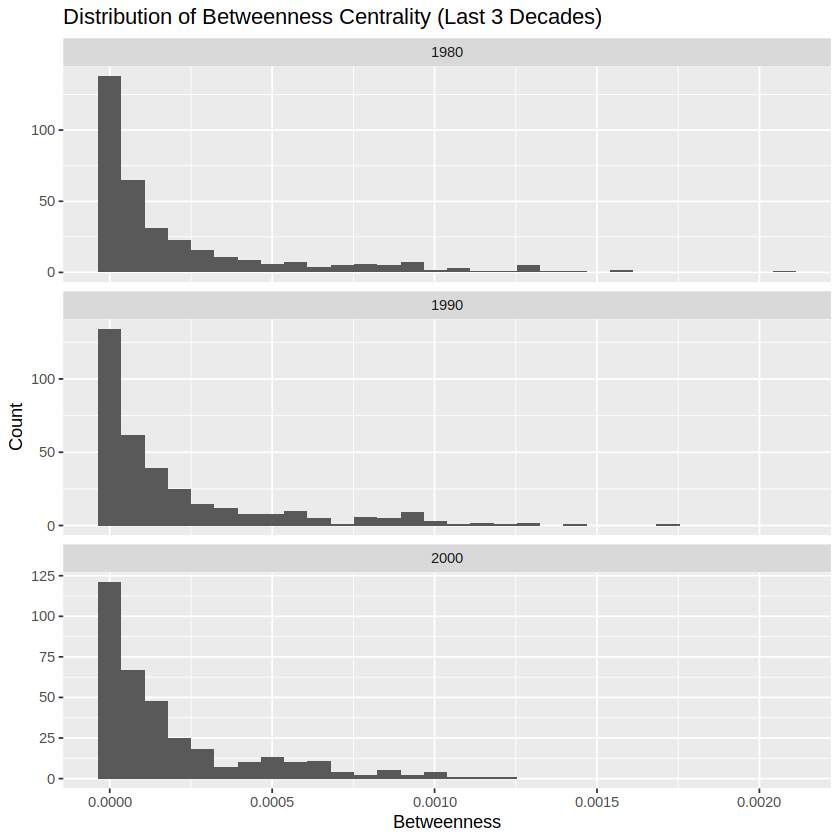

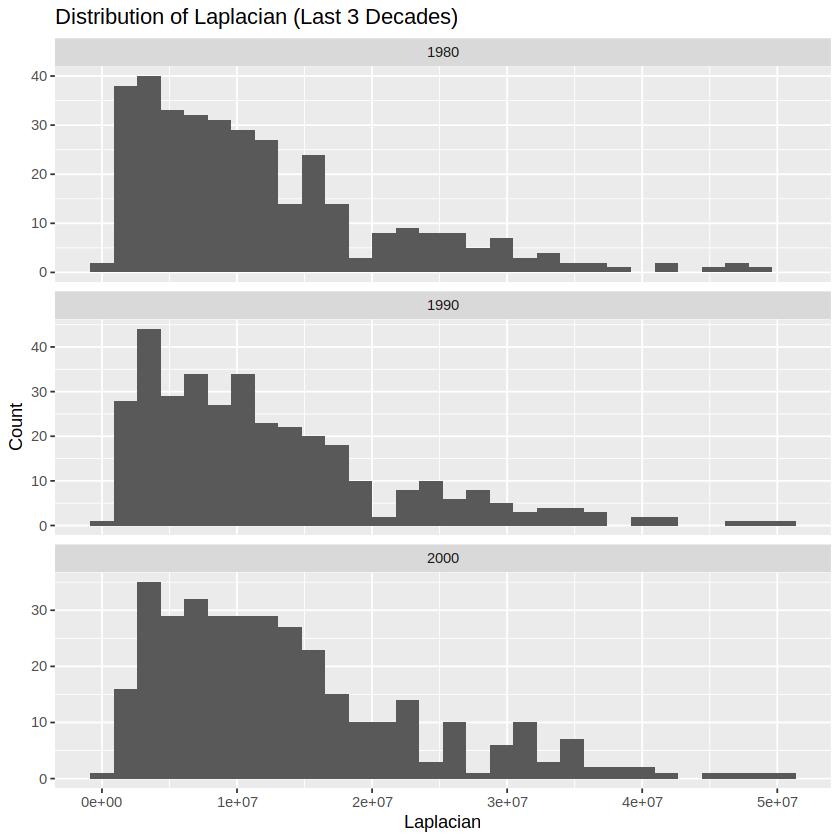

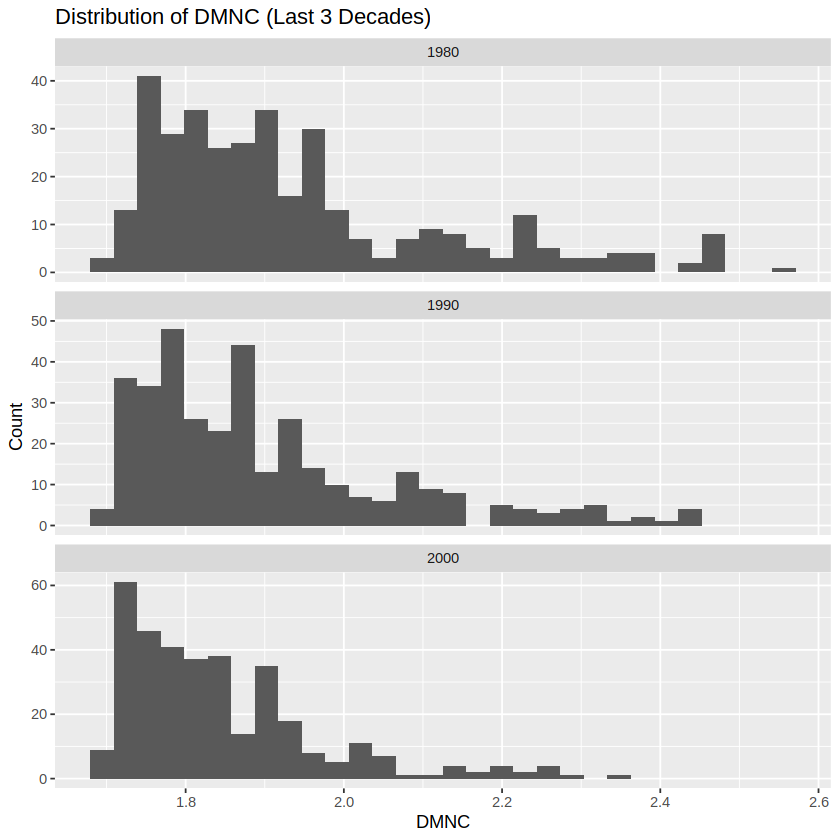

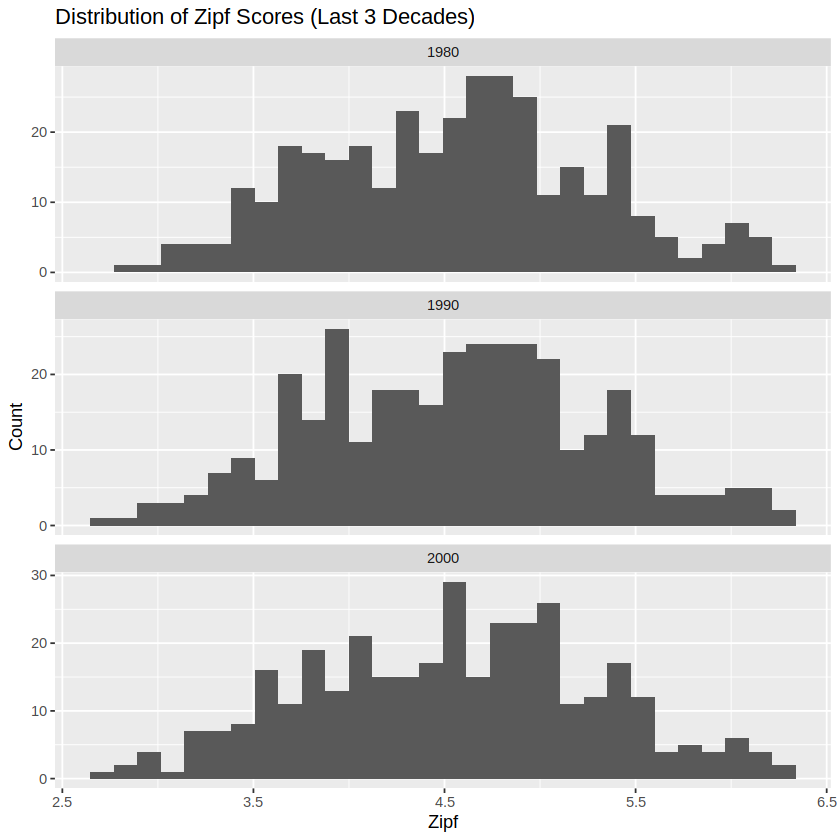

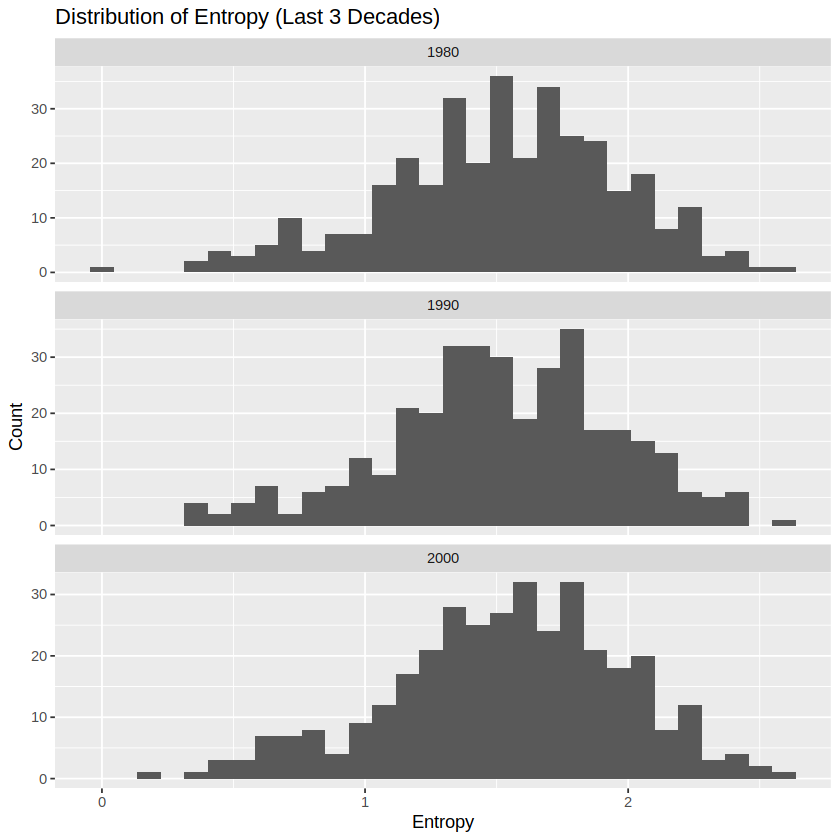

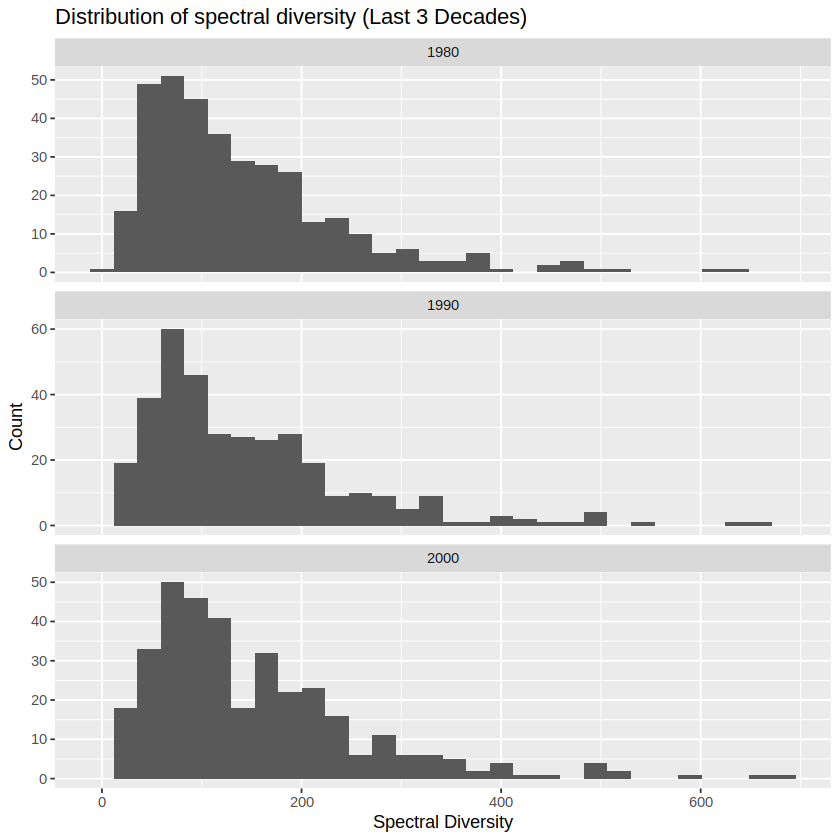

In [12]:


metrics_df_random %>%
  filter(decade %in% tail(sort(unique(decade)), 3)) %>%
  ggplot(aes(x = betweenness)) +
  geom_histogram(bins = 30) +
  facet_wrap(~ decade, ncol = 1, scales = "free_y") +
  labs(
    title = "Distribution of Betweenness Centrality (Last 3 Decades)",
    x = "Betweenness",
    y = "Count"
  )
metrics_df_random %>%
  filter(decade %in% tail(sort(unique(decade)), 3)) %>%
  ggplot(aes(x = laplacian)) +
  geom_histogram(bins = 30) +
  facet_wrap(~ decade, ncol = 1, scales = "free_y") +
  labs(
    title = "Distribution of Laplacian (Last 3 Decades)",
    x = "Laplacian",
    y = "Count"
  )
metrics_df_random %>%
  filter(decade %in% tail(sort(unique(decade)), 3)) %>%
  ggplot(aes(x = dmnc)) +
  geom_histogram(bins = 30) +
  facet_wrap(~ decade, ncol = 1, scales = "free_y") +
  labs(
    title = "Distribution of DMNC (Last 3 Decades)",
    x = "DMNC",
    y = "Count"
  )


metrics_df_random %>%
  filter(decade %in% tail(sort(unique(decade)), 3)) %>%
  ggplot(aes(x = zipf)) +
  geom_histogram(bins = 30) +
  facet_wrap(~ decade, ncol = 1, scales = "free_y") +
  labs(
    title = "Distribution of Zipf Scores (Last 3 Decades)",
    x = "Zipf",
    y = "Count"
  )

  metrics_df_random %>%
  filter(decade %in% tail(sort(unique(decade)), 3)) %>%
  ggplot(aes(x = entropy)) +
  geom_histogram(bins = 30) +
  facet_wrap(~ decade, ncol = 1, scales = "free_y") +
  labs(
    title = "Distribution of Entropy (Last 3 Decades)",
    x = "Entropy",
    y = "Count"
  )

    metrics_df_random %>%
  filter(decade %in% tail(sort(unique(decade)), 3)) %>%
  ggplot(aes(x = spectral_diversity)) +
  geom_histogram(bins = 30) +
  facet_wrap(~ decade, ncol = 1, scales = "free_y") +
  labs(
    title = "Distribution of spectral diversity (Last 3 Decades)",
    x = "Spectral Diversity",
    y = "Count"
  )




## 2. General Correlations

Are words more likely to become frequent by virtue of their central positions in a network? Are more polysemous words *naturally* more central, or does occupying a central hub encourage meanings to proliferate?

These are questions that we aim to answer with COHA time series versions of these variables.

Note: we are looking at three general properties:
- semantic diversity
- frequency
- network centrality

We have three measures of semantic diversity and 14 measures of network centrality. For the sake of this analysis, we will restrict ourselves to the network and semantic diversity measures we know are meaningful post-hoc.

Let's start by looking at correlations:

#### Aggregate:

`geom_smooth()` using formula = 'y ~ x'


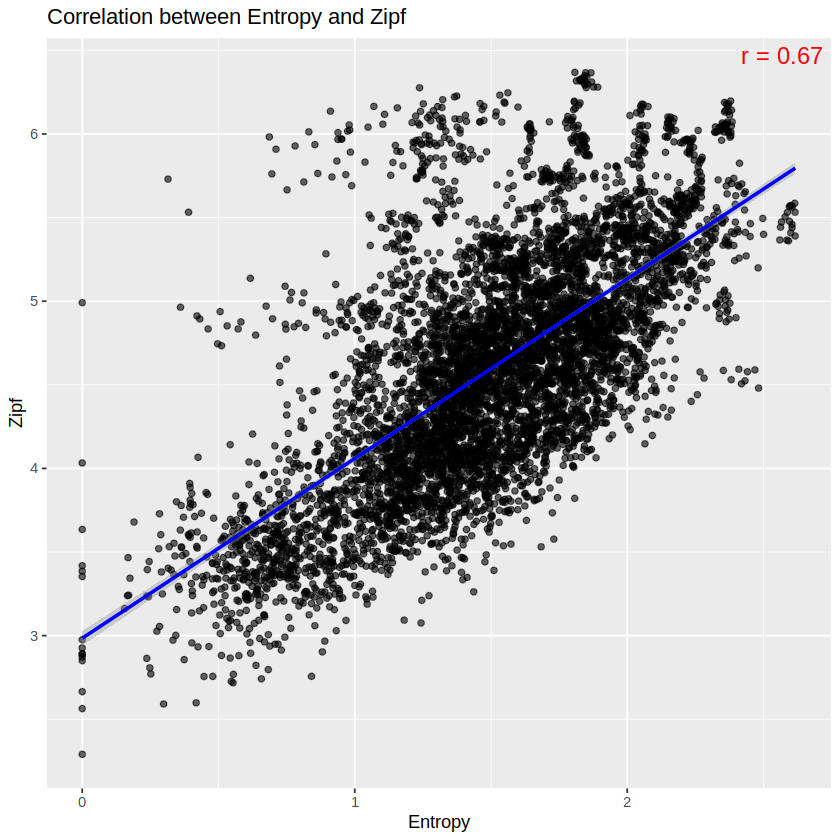

In [18]:
corr_val <- round(cor(metrics_df_random$entropy, metrics_df_random$zipf, use = "complete.obs"), 2)

ggplot(metrics_df_random, aes(x = entropy, y = zipf)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = TRUE) +
  annotate("text", 
           x = Inf, y = Inf, 
           label = paste("r =", corr_val),
           hjust = 1.1, vjust = 1.5,
           size = 5, color = "red") +
  labs(
    title = "Correlation between Entropy and Zipf",
    x = "Entropy",
    y = "Zipf"
  )

`geom_smooth()` using formula = 'y ~ x'


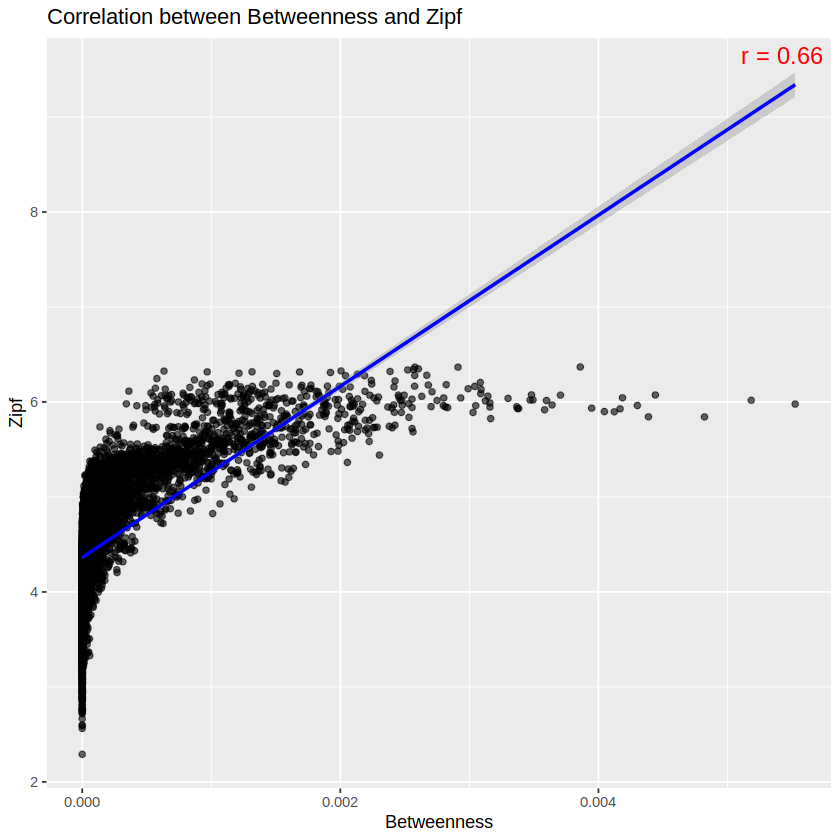

In [19]:
corr_val <- round(cor(metrics_df_random$betweenness, metrics_df_random$zipf, use = "complete.obs"), 2)

ggplot(metrics_df_random, aes(x = betweenness, y = zipf)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = TRUE) +
  annotate("text", 
           x = Inf, y = Inf, 
           label = paste("r =", corr_val),
           hjust = 1.1, vjust = 1.5,
           size = 5, color = "red") +
  labs(
    title = "Correlation between Betweenness and Zipf",
    x = "Betweenness",
    y = "Zipf"
  )

`geom_smooth()` using formula = 'y ~ x'


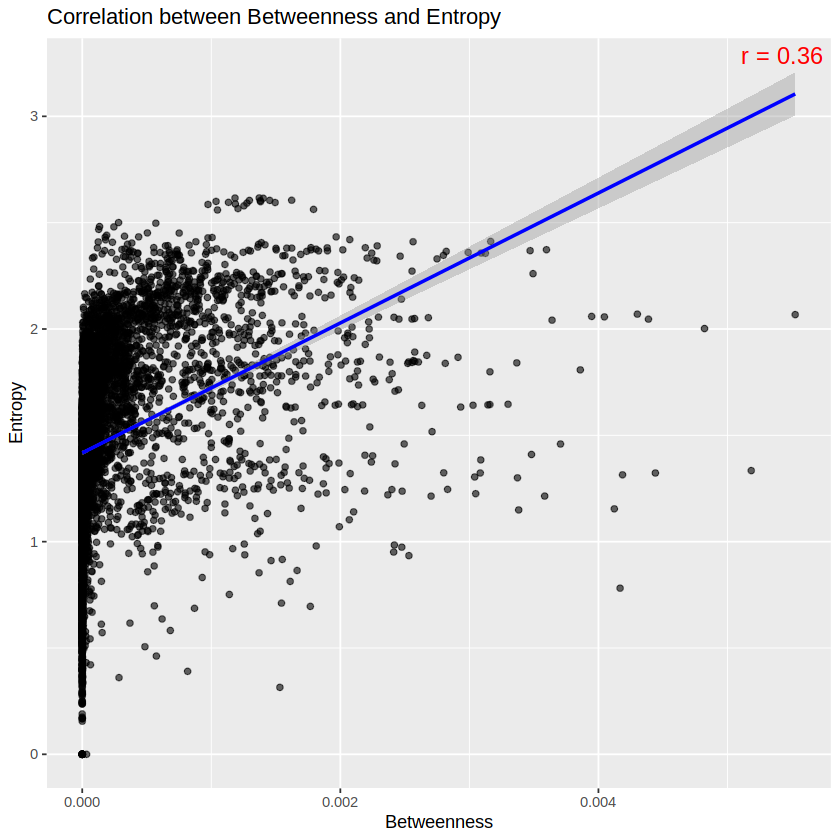

In [20]:
corr_val <- round(cor(metrics_df_random$betweenness, metrics_df_random$entropy, use = "complete.obs"), 2)

ggplot(metrics_df_random, aes(x = betweenness, y = entropy)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = TRUE) +
  annotate("text", 
           x = Inf, y = Inf, 
           label = paste("r =", corr_val),
           hjust = 1.1, vjust = 1.5,
           size = 5, color = "red") +
  labs(
    title = "Correlation between Betweenness and Entropy",
    x = "Betweenness",
    y = "Entropy"
  )

#### By decade:

`geom_smooth()` using formula = 'y ~ x'


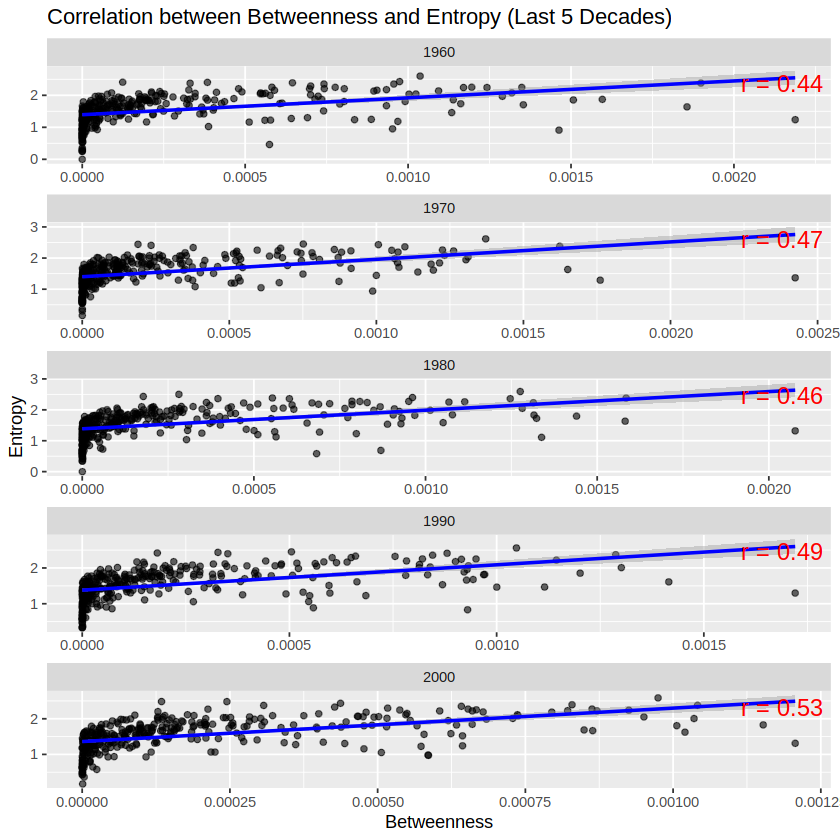

In [21]:
library(ggplot2)
library(dplyr)

# Get last 5 decades
last_5_decades <- tail(sort(unique(metrics_df_random$decade)), 5)

# Filter the data
filtered_df <- metrics_df_random %>%
  filter(decade %in% last_5_decades)

# Compute correlation per decade
cor_df <- filtered_df %>%
  group_by(decade) %>%
  summarize(
    corr = round(cor(betweenness, entropy, use = "complete.obs"), 2),
    .groups = 'drop'
  )

# Plot with facet and add correlation text
ggplot(filtered_df, aes(x = betweenness, y = entropy)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = TRUE) +
  facet_wrap(~ decade, ncol = 1, scales = "free") +
  geom_text(
    data = cor_df,
    aes(x = Inf, y = Inf, label = paste("r =", corr)),
    hjust = 1.1, vjust = 1.5,
    size = 5, color = "red",
    inherit.aes = FALSE
  ) +
  labs(
    title = "Correlation between Betweenness and Entropy (Last 5 Decades)",
    x = "Betweenness",
    y = "Entropy"
  )


`geom_smooth()` using formula = 'y ~ x'


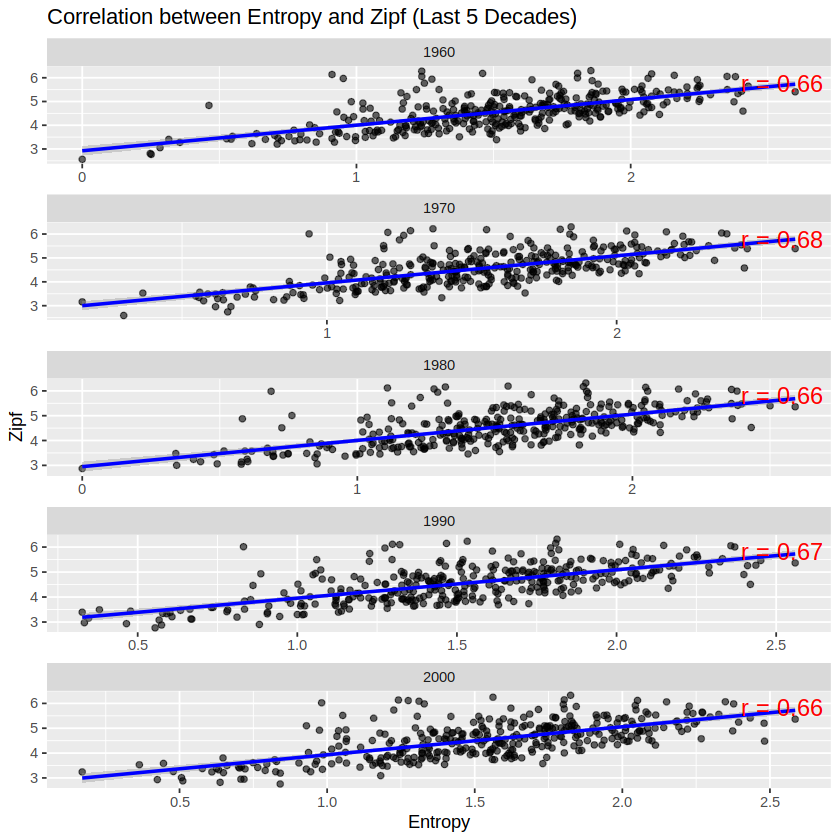

In [23]:
library(ggplot2)
library(dplyr)

# Get last 5 decades
last_5_decades <- tail(sort(unique(metrics_df_random$decade)), 5)

# Filter the data
filtered_df <- metrics_df_random %>%
  filter(decade %in% last_5_decades)

# Compute correlation per decade
cor_df <- filtered_df %>%
  group_by(decade) %>%
  summarize(
    corr = round(cor(entropy, zipf, use = "complete.obs"), 2),
    .groups = 'drop'
  )

# Plot with facet and add correlation text
ggplot(filtered_df, aes(x = entropy, y = zipf)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = TRUE) +
  facet_wrap(~ decade, ncol = 1, scales = "free") +
  geom_text(
    data = cor_df,
    aes(x = Inf, y = Inf, label = paste("r =", corr)),
    hjust = 1.1, vjust = 1.5,
    size = 5, color = "red",
    inherit.aes = FALSE
  ) +
  labs(
    title = "Correlation between Entropy and Zipf (Last 5 Decades)",
    x = "Entropy",
    y = "Zipf"
  )


A few observations:

1. The relationships between our measures(specifically in the case of centrality relationships) are noticeably not linear

2. The relationships between measures appear strong/correlated

3. There is surprisingly little noise in many of the relationships

4. The global relationships are stable over decades


Additionally, our spectral diversity distribution shows large changes in individual word position, especially in 1820. Because COHA is significantly smaller for 1820, it may be a good idea to drop that decade as it appears to be an outlier

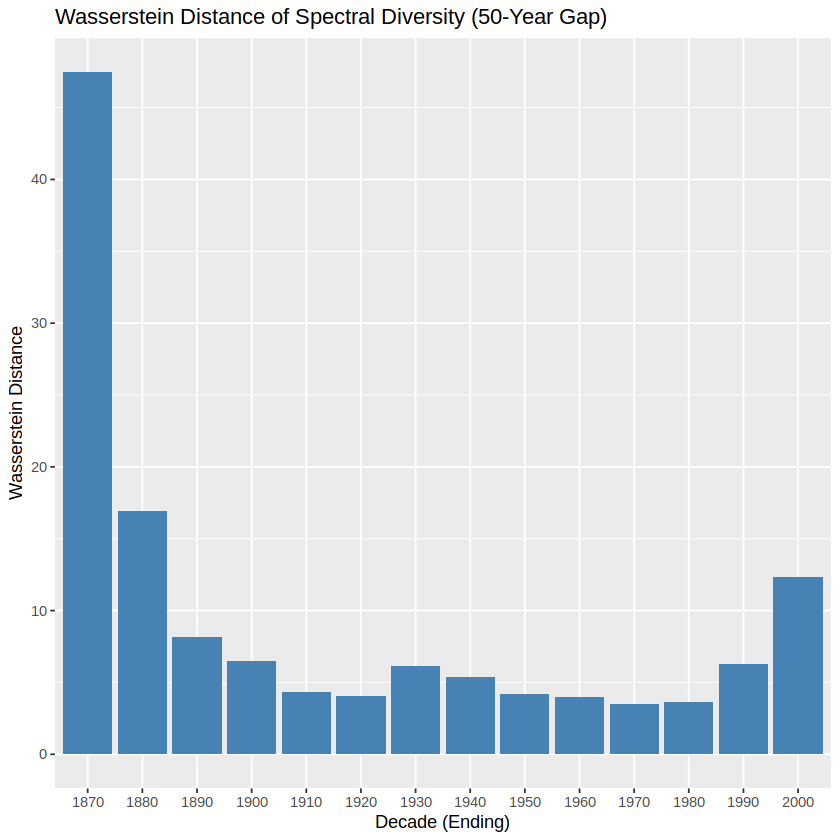

In [45]:
ggplot(wasserstein_spectral_150yr, aes(x = factor(decade2), y = wasserstein)) +
  geom_col(fill = "steelblue") +
  labs(
    title = "Wasserstein Distance of Spectral Diversity (50-Year Gap)",
    x = "Decade (Ending)",
    y = "Wasserstein Distance"
  )




Conversely, the changes in distributions for betweenness are much smaller:

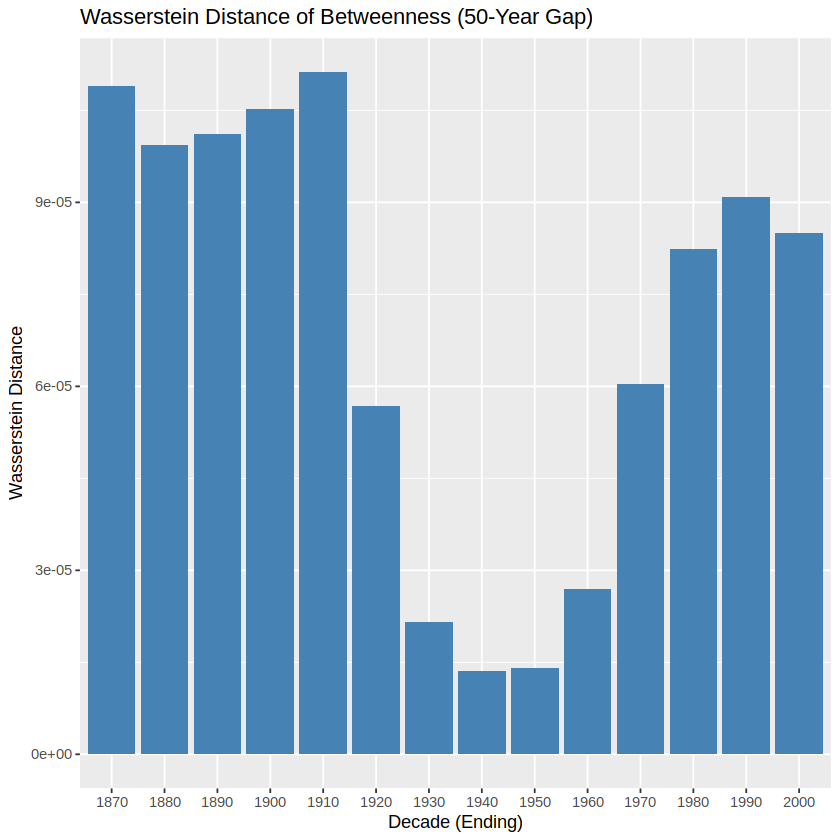

In [46]:
# Set gap to 50 years
gap <- 50

# Initialize results
wasserstein_betweenness_50yr <- data.frame(decade1 = integer(), decade2 = integer(), wasserstein = numeric())

for (i in 1:length(decades)) {
  d1 <- decades[i]
  d2 <- d1 + gap
  
  if (d2 %in% decades) {
    vec1 <- metrics_df_random %>% filter(decade == d1) %>% pull(betweenness)
    vec2 <- metrics_df_random %>% filter(decade == d2) %>% pull(betweenness)
    
    # Compute Wasserstein-1D distance
    wass <- wasserstein1d(vec1, vec2)
    
    wasserstein_betweenness_50yr <- rbind(
      wasserstein_betweenness_50yr,
      data.frame(decade1 = d1, decade2 = d2, wasserstein = wass)
    )
  }
}

ggplot(wasserstein_betweenness_50yr, aes(x = factor(decade2), y = wasserstein)) +
  geom_col(fill = "steelblue") +
  labs(
    title = "Wasserstein Distance of Betweenness (50-Year Gap)",
    x = "Decade (Ending)",
    y = "Wasserstein Distance"
  )

And entropy (a semantic diversity measure), again with an outlier at 1870)

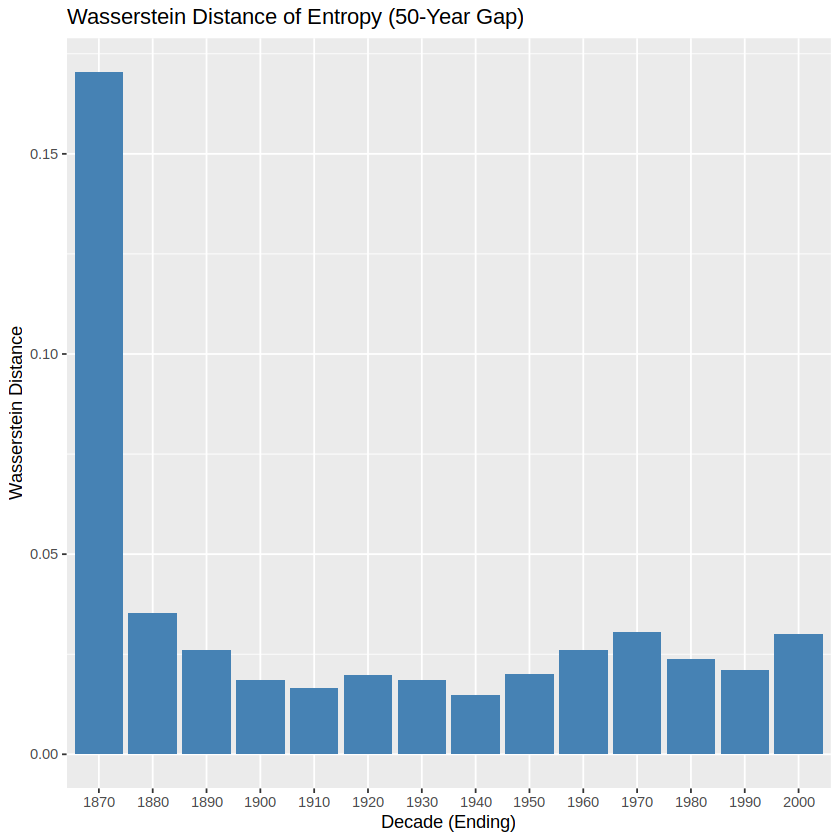

In [48]:
# Set gap to 50 years
gap <- 50
# Set gap to 50 years
gap <- 50

# Initialize results
wasserstein_entropy_50yr <- data.frame(decade1 = integer(), decade2 = integer(), wasserstein = numeric())

for (i in 1:length(decades)) {
  d1 <- decades[i]
  d2 <- d1 + gap
  
  if (d2 %in% decades) {
    vec1 <- metrics_df_random %>% filter(decade == d1) %>% pull(entropy)
    vec2 <- metrics_df_random %>% filter(decade == d2) %>% pull(entropy)
    
    # Compute Wasserstein-1D distance
    wass <- wasserstein1d(vec1, vec2)
    
    wasserstein_entropy_50yr <- rbind(
      wasserstein_entropy_50yr,
      data.frame(decade1 = d1, decade2 = d2, wasserstein = wass)
    )
  }
}

# Initialize results
wasserstein_entropy_50yr <- data.frame(decade1 = integer(), decade2 = integer(), wasserstein = numeric())

for (i in 1:length(decades)) {
  d1 <- decades[i]
  d2 <- d1 + gap
  
  if (d2 %in% decades) {
    vec1 <- metrics_df_random %>% filter(decade == d1) %>% pull(entropy)
    vec2 <- metrics_df_random %>% filter(decade == d2) %>% pull(entropy)
    
    # Compute Wasserstein-1D distance
    wass <- wasserstein1d(vec1, vec2)
    
    wasserstein_entropy_50yr <- rbind(
      wasserstein_entropy_50yr,
      data.frame(decade1 = d1, decade2 = d2, wasserstein = wass)
    )
  }
}
ggplot(wasserstein_entropy_50yr, aes(x = factor(decade2), y = wasserstein)) +
  geom_col(fill = "steelblue") +
  labs(
    title = "Wasserstein Distance of Entropy (50-Year Gap)",
    x = "Decade (Ending)",
    y = "Wasserstein Distance"
  )


## 3. Lagged correlations

We want to test potential causal relationships between these variables. One thing we expect to see intuitively is temporal precedence: if there is a causal relationship from X->Y, we should see that x in an earlier decade t correlates with Y at t+k where k is some number of decades, but X at t+k shouldn't correlate with Y at t (we shouldn't be able to predict later X with earlier Y to the same extent if X->Y)

Let's look at this for our different relationships. For a given relationship (X, Y) from lags 0...k We'll plot the Pearson correlation between X and Y (across all words) where we lag one of the variables for all in the range 0...k. Because we're using Pearson's, we have symmetry in lagging x or y, so we only need to lag one.

** Bootstrap procedure **

1. Shift variable Y by lag t+k
2. Sample variable X at time t
3. Perform 500 bootstrap samples with replacement
4. Get pearson correlation for Y(t+k) and X(t) bootstrap sample
5. Average the 500 correlation estimates to get mean r
6. Get a 95% confidence interval for the uncertainty around the pearson correlation coefficient at lag k

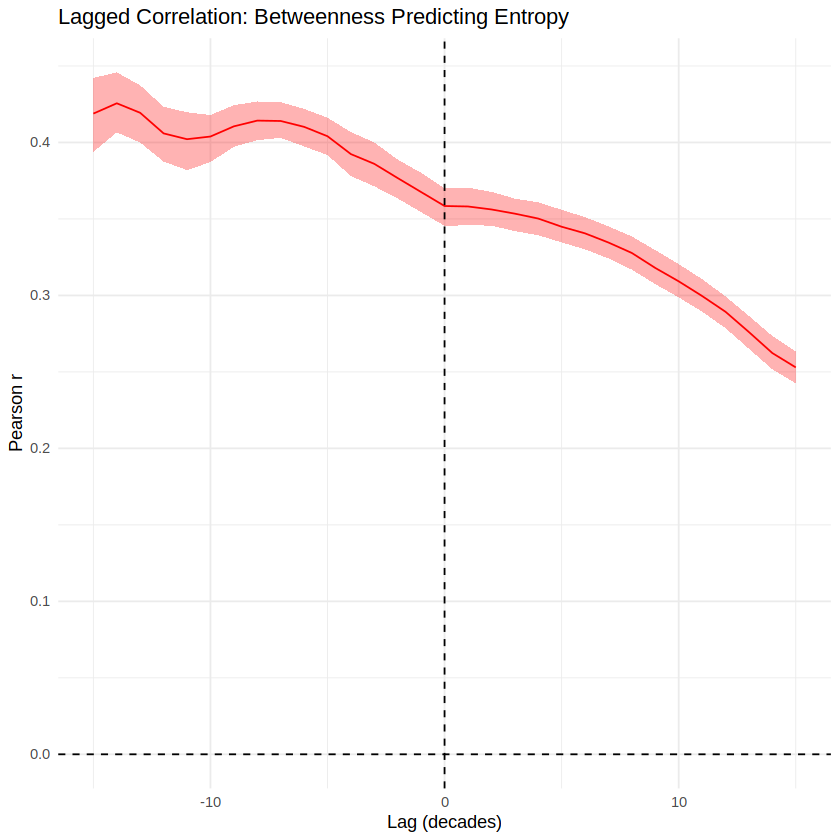

In [51]:
lags <- -15:15
lag_results <- list()

for (lag_val in lags) {
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (lag_val > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = lag_val))
      } else if (lag_val < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(lag_val)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    }

  corr_df <- tmp %>%
  filter(
    !is.na(betweenness_shifted) & !is.na(entropy),
    sd(betweenness_shifted) > 0,
    sd(entropy) > 0
  ) %>%
  summarise(
    r = if (n() > 1) cor(betweenness_shifted, entropy, use = "complete.obs") else NA_real_
  ) %>%
  mutate(lag = lag_val)


  lag_results[[as.character(lag_val)]] <- corr_df
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function (unchanged)
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$betweenness_shifted) == 0 || sd(sample_data$entropy) == 0) {
      NA
    } else {
      cor(sample_data$betweenness_shifted, sample_data$entropy, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop (already correct)
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (lag_val > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = lag_val))
      } else if (lag_val < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(lag_val)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    } %>%
    filter(!is.na(betweenness_shifted) & !is.na(entropy))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_line(color = 'red') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'red', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Betweenness Predicting Entropy',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()


In [ ]:


lags <- -15:15
lag_results <- list()

# Loop: betweenness vs. zipf (with p-values)
for (lag_val in lags) {
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (lag_val > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = lag_val))
      } else if (lag_val < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(lag_val)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    } %>%
    filter(
      !is.na(betweenness_shifted) & !is.na(zipf),
      sd(betweenness_shifted) > 0,
      sd(zipf) > 0
    )

  if (nrow(tmp) > 2) {
    ct <- cor.test(tmp$betweenness_shifted, tmp$zipf)
    lag_results[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      r = ct$estimate,
      p_value = ct$p.value
    )
  } else {
    lag_results[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      r = NA_real_,
      p_value = NA_real_
    )
  }
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function (updated for zipf)
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$betweenness_shifted) == 0 || sd(sample_data$zipf) == 0) {
      NA
    } else {
      cor(sample_data$betweenness_shifted, sample_data$zipf, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop (betweenness vs zipf)
bootstrap_results <- map_dfr(lags, function(lag_val) {
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (lag_val > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = lag_val))
      } else if (lag_val < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(lag_val)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    } %>%
    filter(!is.na(betweenness_shifted) & !is.na(zipf))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Merge p-values into bootstrap results
plot_df <- bootstrap_results %>%
  left_join(all_lags_df %>% select(lag, p_value), by = "lag") %>%
  mutate(sig_label = ifelse(!is.na(p_value) & p_value < 0.05, "*", ""))




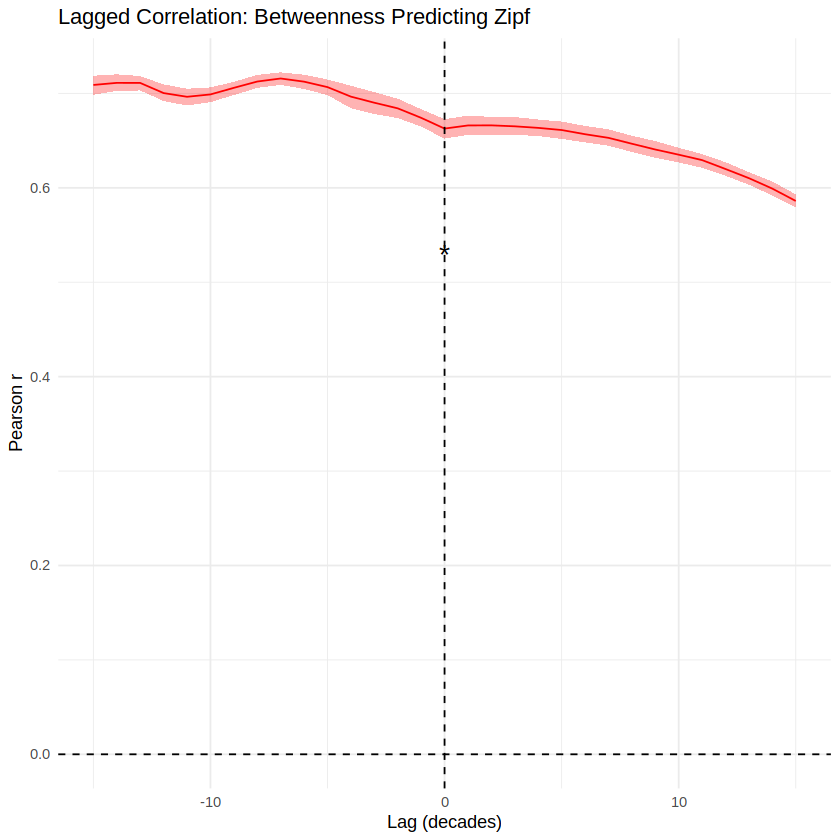

In [54]:
# Plot with asterisks for significance
ggplot(plot_df, aes(x = lag, y = r)) +
  geom_line(color = 'red') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'red', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  geom_text(aes(y = min(ci_low, na.rm = TRUE) - 0.05, label = sig_label), size = 6) +
  labs(
    title = 'Lagged Correlation: Betweenness Predicting Zipf',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()

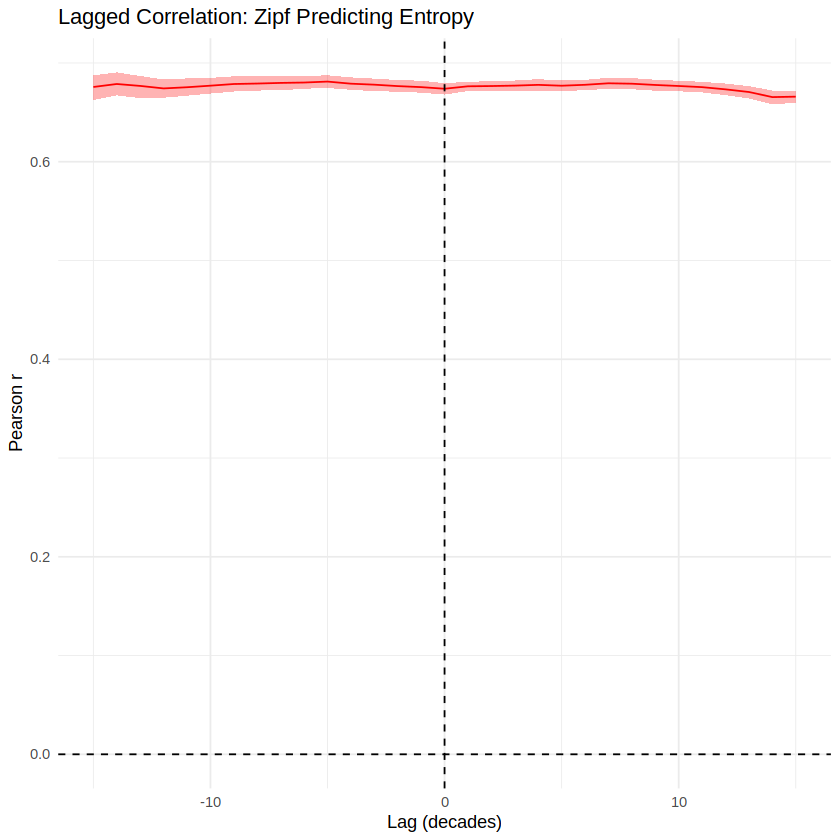

In [55]:
lags <- -15:15

# Bootstrap function: zipf vs entropy
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$zipf) == 0 || sd(sample_data$entropy) == 0) {
      NA
    } else {
      cor(sample_data$zipf, sample_data$entropy, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop (zipf vs entropy)
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (lag_val > 0) {
        mutate(., zipf_shifted = dplyr::lag(zipf, n = lag_val))
      } else if (lag_val < 0) {
        mutate(., zipf_shifted = dplyr::lead(zipf, n = abs(lag_val)))
      } else {
        mutate(., zipf_shifted = zipf)
      }
    } %>%
    filter(!is.na(zipf_shifted) & !is.na(entropy))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_line(color = 'red') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'red', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Zipf Predicting Entropy',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()


There's clearly temporal precedence in the relationship for betweenness and entropy(one of our SD measures), betweenness and zipf (to a lesser extent), but *not* between zipf and entropy- we can predict just as well forward vs backward! Now we can start to infer temporal assymmetry from our highly correlated variables.

We can't do granger causality here for a few reasons:

1. Our time series data are not stationary (KPSS test demonstrates this). Log transform and differencing loses the signal naturally present in our data.
2. Insufficient time points: We only have 18 total time points, but Granger casuality ideally has at least 50 observations per measure

To still get an intuition for the predictive effects of our measures, we can regress a response variable on a predictor and it's autocorrelation for a given lag k:

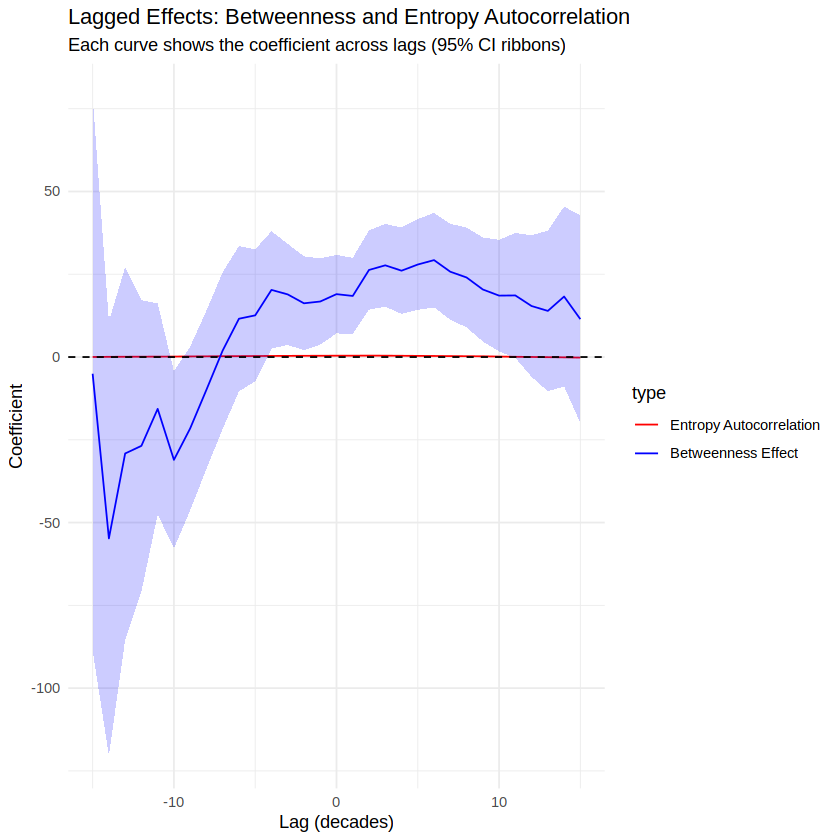

In [61]:
lags <- -15:15
results_list <- list()

for (lag_val in lags) {
  
  # Create lagged betweenness and lagged entropy for this lag
  panel_df_lag <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    mutate(
      betweenness_lag = if (lag_val > 0) dplyr::lag(betweenness, n = lag_val)
                        else if (lag_val < 0) dplyr::lead(betweenness, n = abs(lag_val))
                        else betweenness,
      entropy_lag1 = dplyr::lag(entropy, n = 1)
    ) %>%
    ungroup()
  
  # Fit the panel regression for this lag
  model <- tryCatch({
    plm::plm(
      entropy ~ entropy_lag1 + betweenness_lag,
      data = panel_df_lag,
      index = c("word", "decade"),
      model = "within"
    )
  }, error = function(e) NULL)
  
  if (!is.null(model)) {
    coef_summary <- summary(model)$coefficients
    
    results_list[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      betweenness_coef = if ("betweenness_lag" %in% rownames(coef_summary)) coef_summary["betweenness_lag", "Estimate"] else NA_real_,
      betweenness_se = if ("betweenness_lag" %in% rownames(coef_summary)) coef_summary["betweenness_lag", "Std. Error"] else NA_real_,
      betweenness_p = if ("betweenness_lag" %in% rownames(coef_summary)) coef_summary["betweenness_lag", "Pr(>|t|)"] else NA_real_,
      
      autocorr_coef = if ("entropy_lag1" %in% rownames(coef_summary)) coef_summary["entropy_lag1", "Estimate"] else NA_real_,
      autocorr_se = if ("entropy_lag1" %in% rownames(coef_summary)) coef_summary["entropy_lag1", "Std. Error"] else NA_real_,
      autocorr_p = if ("entropy_lag1" %in% rownames(coef_summary)) coef_summary["entropy_lag1", "Pr(>|t|)"] else NA_real_
    )
  } else {
    results_list[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      betweenness_coef = NA,
      betweenness_se = NA,
      betweenness_p = NA,
      autocorr_coef = NA,
      autocorr_se = NA,
      autocorr_p = NA
    )
  }
}

# Combine results
all_lags_df <- dplyr::bind_rows(results_list)

# Pivot to long format (type = betweenness/autocorr; measure = coef/se)
long_df <- all_lags_df %>%
  tidyr::pivot_longer(
    cols = c(betweenness_coef, autocorr_coef, betweenness_se, autocorr_se),
    names_to = c("type", "measure"),
    names_sep = "_",
    values_to = "value"
  ) %>%
  tidyr::pivot_wider(
    names_from = measure,
    values_from = value
  )

# Plot both lines with confidence bands
ggplot(long_df, aes(x = lag, y = coef, color = type, fill = type)) +
  geom_line() +
  geom_ribbon(aes(ymin = coef - 1.96 * se, ymax = coef + 1.96 * se),
              alpha = 0.2, color = NA) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Effects: Betweenness and Entropy Autocorrelation',
    subtitle = 'Each curve shows the coefficient across lags (95% CI ribbons)',
    x = 'Lag (decades)',
    y = 'Coefficient'
  ) +
  scale_color_manual(values = c('betweenness' = 'blue', 'autocorr' = 'red'),
                     labels = c('Entropy Autocorrelation', 'Betweenness Effect')) +
  scale_fill_manual(values = c('betweenness' = 'blue', 'autocorr' = 'red'),
                    guide = 'none') +
  theme_minimal()


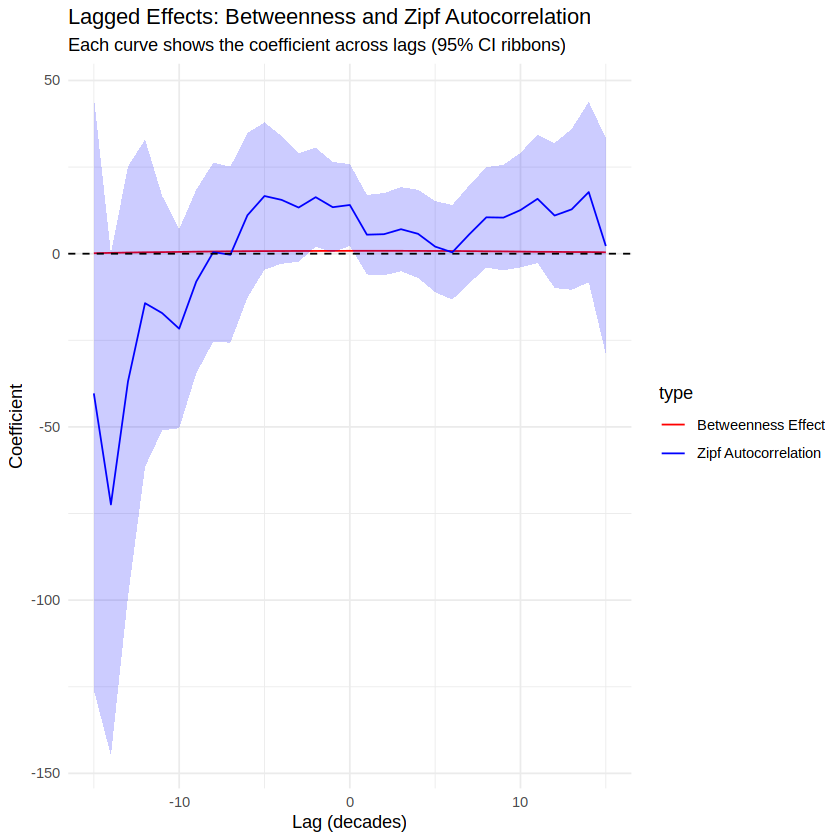

In [62]:
lags <- -15:15
results_list <- list()

for (lag_val in lags) {
  
  # Create lagged betweenness and lagged zipf for this lag
  panel_df_lag <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    mutate(
      betweenness_lag = if (lag_val > 0) dplyr::lag(betweenness, n = lag_val)
                        else if (lag_val < 0) dplyr::lead(betweenness, n = abs(lag_val))
                        else betweenness,
      zipf_lag1 = dplyr::lag(zipf, n = 1)
    ) %>%
    ungroup()
  
  # Fit the panel regression for this lag
  model <- tryCatch({
    plm::plm(
      zipf ~ zipf_lag1 + betweenness_lag,
      data = panel_df_lag,
      index = c("word", "decade"),
      model = "within"
    )
  }, error = function(e) NULL)
  
  if (!is.null(model)) {
    coef_summary <- summary(model)$coefficients
    
    results_list[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      betweenness_coef = if ("betweenness_lag" %in% rownames(coef_summary)) coef_summary["betweenness_lag", "Estimate"] else NA_real_,
      betweenness_se = if ("betweenness_lag" %in% rownames(coef_summary)) coef_summary["betweenness_lag", "Std. Error"] else NA_real_,
      betweenness_p = if ("betweenness_lag" %in% rownames(coef_summary)) coef_summary["betweenness_lag", "Pr(>|t|)"] else NA_real_,
      
      autocorr_coef = if ("zipf_lag1" %in% rownames(coef_summary)) coef_summary["zipf_lag1", "Estimate"] else NA_real_,
      autocorr_se = if ("zipf_lag1" %in% rownames(coef_summary)) coef_summary["zipf_lag1", "Std. Error"] else NA_real_,
      autocorr_p = if ("zipf_lag1" %in% rownames(coef_summary)) coef_summary["zipf_lag1", "Pr(>|t|)"] else NA_real_
    )
  } else {
    results_list[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      betweenness_coef = NA,
      betweenness_se = NA,
      betweenness_p = NA,
      autocorr_coef = NA,
      autocorr_se = NA,
      autocorr_p = NA
    )
  }
}

# Combine results
all_lags_df <- dplyr::bind_rows(results_list)

# Pivot to long format (type = betweenness/autocorr; measure = coef/se)
long_df <- all_lags_df %>%
  tidyr::pivot_longer(
    cols = c(betweenness_coef, autocorr_coef, betweenness_se, autocorr_se),
    names_to = c("type", "measure"),
    names_sep = "_",
    values_to = "value"
  ) %>%
  tidyr::pivot_wider(
    names_from = measure,
    values_from = value
  )

# Plot both lines with confidence bands
ggplot(long_df, aes(x = lag, y = coef, color = type, fill = type)) +
  geom_line() +
  geom_ribbon(aes(ymin = coef - 1.96 * se, ymax = coef + 1.96 * se),
              alpha = 0.2, color = NA) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Effects: Betweenness and Zipf Autocorrelation',
    subtitle = 'Each curve shows the coefficient across lags (95% CI ribbons)',
    x = 'Lag (decades)',
    y = 'Coefficient'
  ) +
  scale_color_manual(values = c('betweenness' = 'blue', 'autocorr' = 'red'),
                     labels = c('Betweenness Effect', 'Zipf Autocorrelation')) +
  scale_fill_manual(values = c('betweenness' = 'blue', 'autocorr' = 'red'),
                    guide = 'none') +
  theme_minimal()


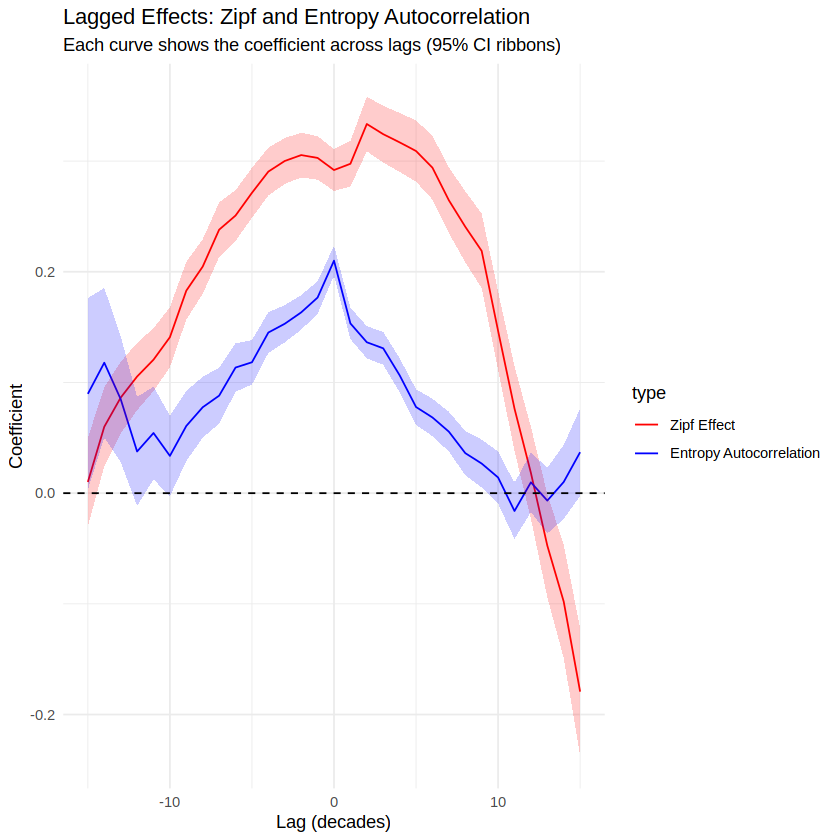

In [63]:
lags <- -15:15
results_list <- list()

for (lag_val in lags) {
  
  # Create lagged zipf and lagged entropy for this lag
  panel_df_lag <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    mutate(
      zipf_lag = if (lag_val > 0) dplyr::lag(zipf, n = lag_val)
                 else if (lag_val < 0) dplyr::lead(zipf, n = abs(lag_val))
                 else zipf,
      entropy_lag1 = dplyr::lag(entropy, n = 1)
    ) %>%
    ungroup()
  
  # Fit the panel regression for this lag
  model <- tryCatch({
    plm::plm(
      entropy ~ entropy_lag1 + zipf_lag,
      data = panel_df_lag,
      index = c("word", "decade"),
      model = "within"
    )
  }, error = function(e) NULL)
  
  if (!is.null(model)) {
    coef_summary <- summary(model)$coefficients
    
    results_list[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      zipf_coef = if ("zipf_lag" %in% rownames(coef_summary)) coef_summary["zipf_lag", "Estimate"] else NA_real_,
      zipf_se = if ("zipf_lag" %in% rownames(coef_summary)) coef_summary["zipf_lag", "Std. Error"] else NA_real_,
      zipf_p = if ("zipf_lag" %in% rownames(coef_summary)) coef_summary["zipf_lag", "Pr(>|t|)"] else NA_real_,
      
      autocorr_coef = if ("entropy_lag1" %in% rownames(coef_summary)) coef_summary["entropy_lag1", "Estimate"] else NA_real_,
      autocorr_se = if ("entropy_lag1" %in% rownames(coef_summary)) coef_summary["entropy_lag1", "Std. Error"] else NA_real_,
      autocorr_p = if ("entropy_lag1" %in% rownames(coef_summary)) coef_summary["entropy_lag1", "Pr(>|t|)"] else NA_real_
    )
  } else {
    results_list[[as.character(lag_val)]] <- tibble(
      lag = lag_val,
      zipf_coef = NA,
      zipf_se = NA,
      zipf_p = NA,
      autocorr_coef = NA,
      autocorr_se = NA,
      autocorr_p = NA
    )
  }
}

# Combine results
all_lags_df <- dplyr::bind_rows(results_list)

# Pivot to long format (type = zipf/autocorr; measure = coef/se)
long_df <- all_lags_df %>%
  tidyr::pivot_longer(
    cols = c(zipf_coef, autocorr_coef, zipf_se, autocorr_se),
    names_to = c("type", "measure"),
    names_sep = "_",
    values_to = "value"
  ) %>%
  tidyr::pivot_wider(
    names_from = measure,
    values_from = value
  )

# Plot both lines with confidence bands
ggplot(long_df, aes(x = lag, y = coef, color = type, fill = type)) +
  geom_line() +
  geom_ribbon(aes(ymin = coef - 1.96 * se, ymax = coef + 1.96 * se),
              alpha = 0.2, color = NA) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Effects: Zipf and Entropy Autocorrelation',
    subtitle = 'Each curve shows the coefficient across lags (95% CI ribbons)',
    x = 'Lag (decades)',
    y = 'Coefficient'
  ) +
  scale_color_manual(values = c('zipf' = 'blue', 'autocorr' = 'red'),
                     labels = c('Zipf Effect', 'Entropy Autocorrelation')) +
  scale_fill_manual(values = c('zipf' = 'blue', 'autocorr' = 'red'),
                    guide = 'none') +
  theme_minimal()


This aligns with the intuitions from our earlier bootstrapped pearson r intervals. For our network centrality predictor betweenness, we see:

1. A strong temporal precedence in absolute effect size in predicting frequency and entropy
2. A near 0 predictive effect for the coefficient of the autocorrelated variable

For zipf and entropy, by contrast, we see:
1. Temporal symmetry- we get no more predictive power at time t + k as opposed to time t - k
2. Higher autocorrelation predictive power


What can we say at this point?

1. Centrality is a good predictor of frequency and semantic diversity above and beyond a words own autocorrelated past measures
2. Temporal assymetry suggests a potential causal effect: earlier effect in centrality predicts later effect in semantic diversity/frequency


What are the current issues with this analysis?
1. *Linear assumptions*: Pearson's, linear regression, granger cause assume linear relationships. As seen above, many of our relationships are decidedly *not* linear. as a reminder:

`geom_smooth()` using formula = 'y ~ x'


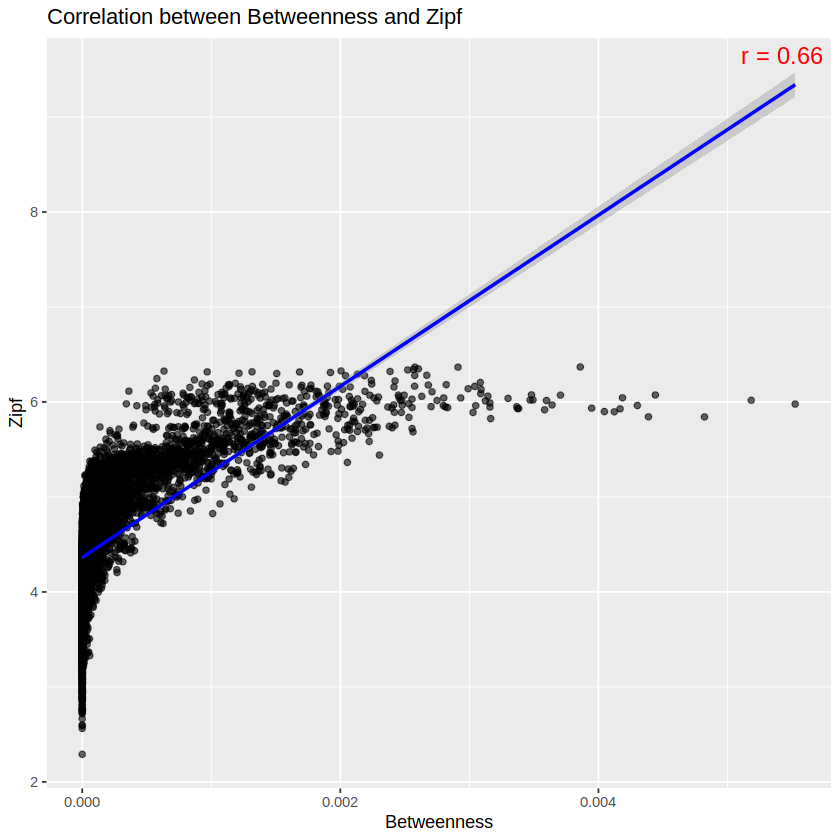

In [66]:
corr_val <- round(cor(metrics_df_random$betweenness, metrics_df_random$zipf, use = "complete.obs"), 2)

ggplot(metrics_df_random, aes(x = betweenness, y = zipf)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = TRUE) +
  annotate("text", 
           x = Inf, y = Inf, 
           label = paste("r =", corr_val),
           hjust = 1.1, vjust = 1.5,
           size = 5, color = "red") +
  labs(
    title = "Correlation between Betweenness and Zipf",
    x = "Betweenness",
    y = "Zipf"
  )

2. Heteroskedasticity: Our residuals are most-definitely non linear, with the exception of entropy

`geom_smooth()` using formula = 'y ~ x'


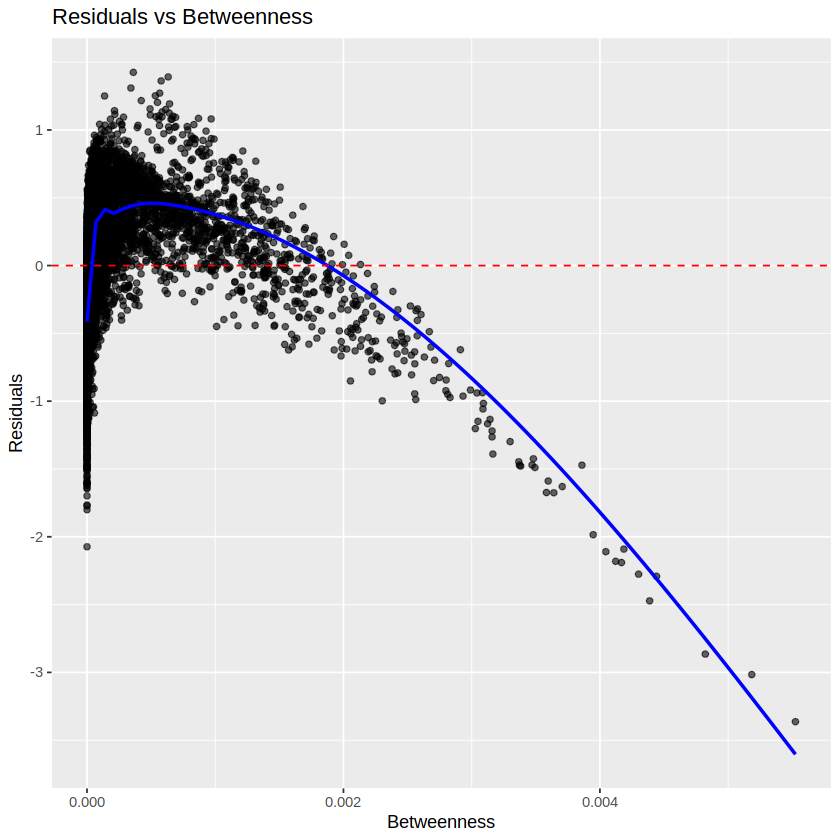

In [67]:
model_betweenness_zipf <- lm(zipf ~ betweenness, data = metrics_df_random)
ggplot(metrics_df_random, aes(x = betweenness, y = resid(model_betweenness_zipf))) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE, color = "blue") +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Residuals vs Betweenness",
    x = "Betweenness",
    y = "Residuals"
  )


`geom_smooth()` using formula = 'y ~ x'


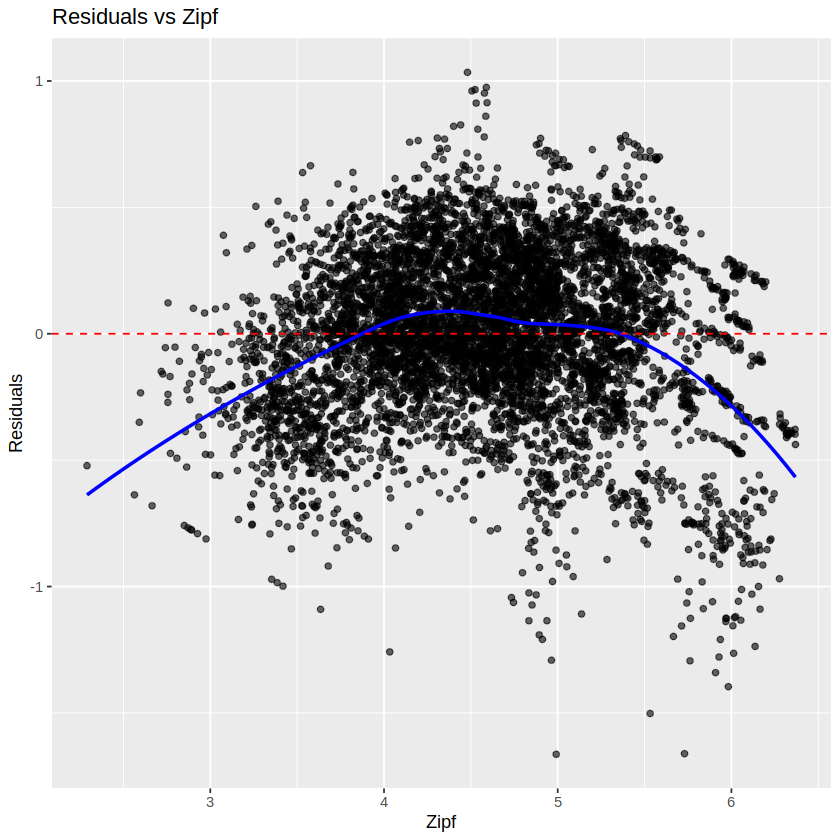

In [68]:
# Fit simple OLS model: entropy ~ zipf
model_entropy_zipf <- lm(entropy ~ zipf, data = metrics_df_random)

# Plot residuals vs zipf
ggplot(metrics_df_random, aes(x = zipf, y = resid(model_entropy_zipf))) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE, color = "blue") +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Residuals vs Zipf",
    x = "Zipf",
    y = "Residuals"
  )


`geom_smooth()` using formula = 'y ~ x'


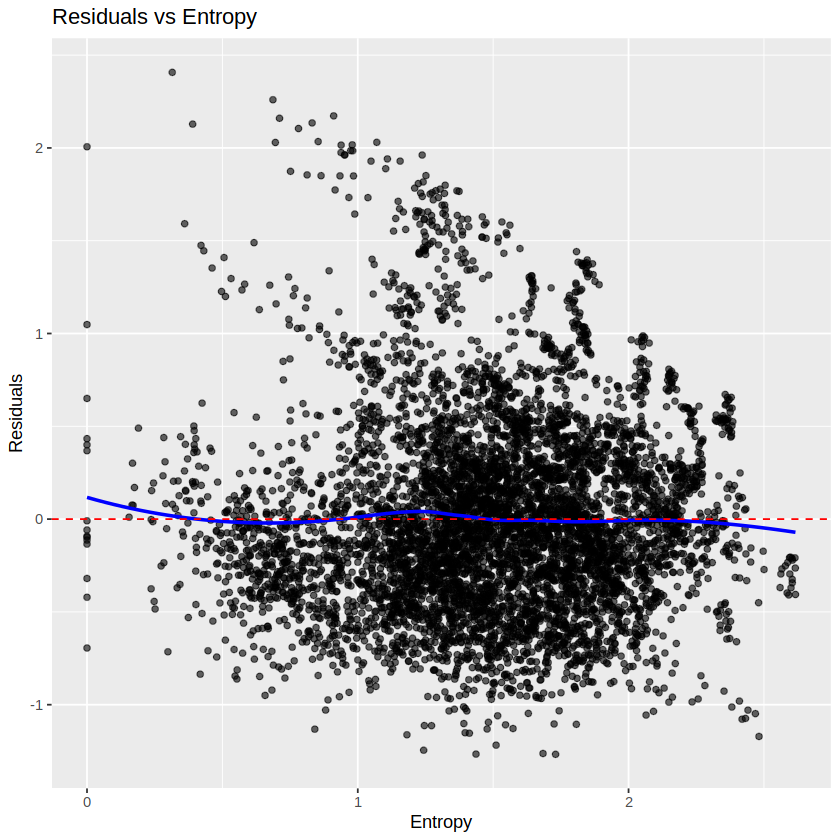

In [69]:
# Fit model: zipf ~ entropy
model_zipf_entropy <- lm(zipf ~ entropy, data = metrics_df_random)

# Plot residuals vs entropy
ggplot(metrics_df_random, aes(x = entropy, y = resid(model_zipf_entropy))) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE, color = "blue") +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Residuals vs Entropy",
    x = "Entropy",
    y = "Residuals"
  )


3. Influence of outliers and temporal direction: we cannot infer either of these from a classic linear regression or pearson's r, though the autocorrelation regression comparisons suggest significant, temporally asymmetric predictive power in our centrality measure 

## 4. Motivation for *generalized* measures of correlation (GMC)

We clearly have non-linear relationships throughout our measures, which make linear methods unsuitable. Zheng et al. (2010) introduces a generalized version of pearson's r called *generalized measures of correlation*. While GMC may appear complex at first glance, the motivation is simple. Here I'll walk through how we go from basic ideas of explained variance to our GMC measure.

### 4a. GMC introduction and formula

As the author's write:

*Applicability of Pearson’s correlation as a measure of explained variance is by now well
understood. One of its limitations is that it does not account for asymmetry in explained variance.
Aiming to develop broad applicable correlation measures, we propose a pair of generalized
measures of correlation (GMC) which deal with asymmetries in explained variances, and linear
or nonlinear relations between random variables.*

Seems like a good fit! let's look closer:

From the paper:

2.1 Generalized measures of correlation


*In computing coefficient of determination in a linear regression model, the total variation in response
variable is partitioned into two component sums of squares, i.e. explained variation due to regression
and unexplained variation. Here, we shall introduce our generalized measures of correlation based
on a well known variance decomposition formula:*

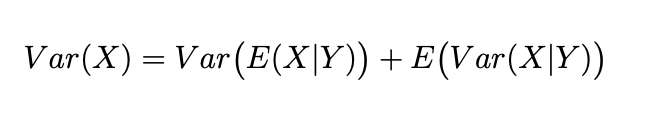



Let's look at this in our data- we can see intuitively that the explained variance and the unexplained variance sum to the total variance. Makes sense.


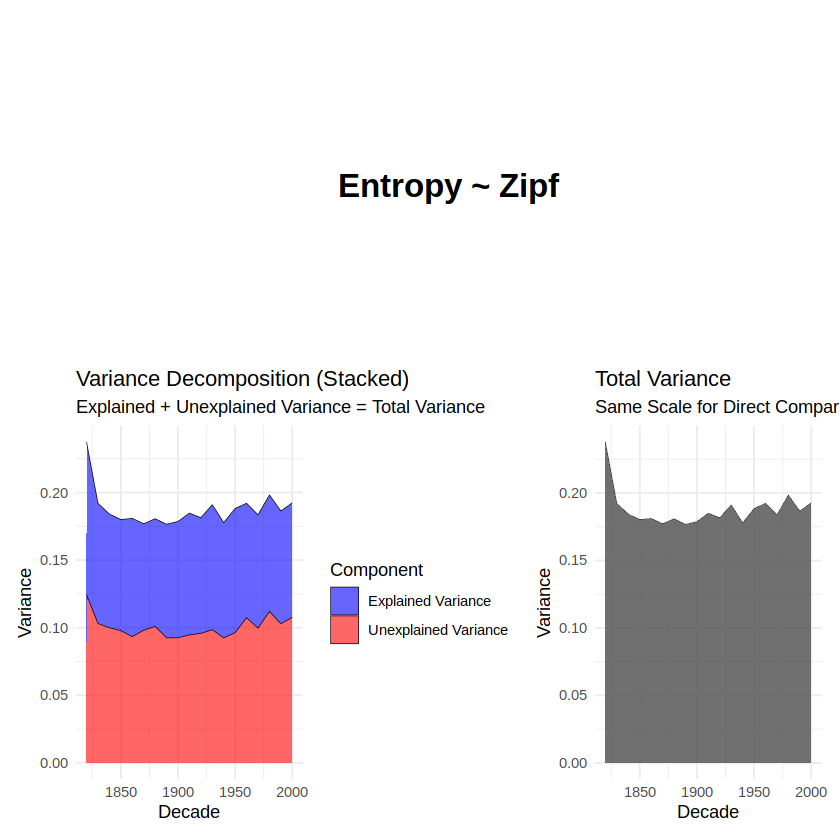

In [90]:
library(dplyr)
library(ggplot2)
library(patchwork)

# 1️⃣ Calculate variance decomposition by decade
variance_by_decade <- metrics_df_random %>%
  group_by(decade) %>%
  summarise(
    total_var = var(entropy, na.rm = TRUE),
    explained_var = var(predict(lm(entropy ~ zipf, data = cur_data())), na.rm = TRUE),
    unexplained_var = mean((entropy - predict(lm(entropy ~ zipf, data = cur_data())))^2, na.rm = TRUE),
    .groups = 'drop'
  )

# 2️⃣ Pivot longer for the stacked area plot
variance_long <- variance_by_decade %>%
  select(decade, explained_var, unexplained_var) %>%
  tidyr::pivot_longer(
    cols = c(explained_var, unexplained_var),
    names_to = "Component",
    values_to = "Variance"
  )

# 3️⃣ Stacked area plot
p1 <- ggplot(variance_long, aes(x = decade, y = Variance, fill = Component)) +
  geom_area(alpha = 0.6, color = "black", size = 0.2) +
  labs(
    title = "Variance Decomposition (Stacked)",
    subtitle = "Explained + Unexplained Variance = Total Variance",
    x = "Decade",
    y = "Variance"
  ) +
  scale_fill_manual(
    values = c(
      "explained_var" = "blue",
      "unexplained_var" = "red"
    ),
    labels = c(
      "explained_var" = "Explained Variance",
      "unexplained_var" = "Unexplained Variance"
    )
  ) +
  theme_minimal()

# 4️⃣ Volume-style plot for total variance
p2 <- ggplot(variance_by_decade, aes(x = decade, y = total_var)) +
  geom_area(fill = "gray30", alpha = 0.8, color = "black", size = 0.1) +
  labs(
    title = "Total Variance",
    subtitle = "Same Scale for Direct Comparison",
    x = "Decade",
    y = "Variance"
  ) +
  ylim(0, max(variance_by_decade$total_var, na.rm = TRUE)) +
  theme_minimal()

# 5️⃣ Add a simple label: "Entropy ~ Zipf"
label_plot <- ggplot() +
  annotate(
    "text",
    x = 0.5, y = 0.5,
    label = "Entropy ~ Zipf",
    size = 7, fontface = "bold"
  ) +
  theme_void()

# 6️⃣ Combine all: label on top, then plots side by side
label_plot / (p1 + p2)


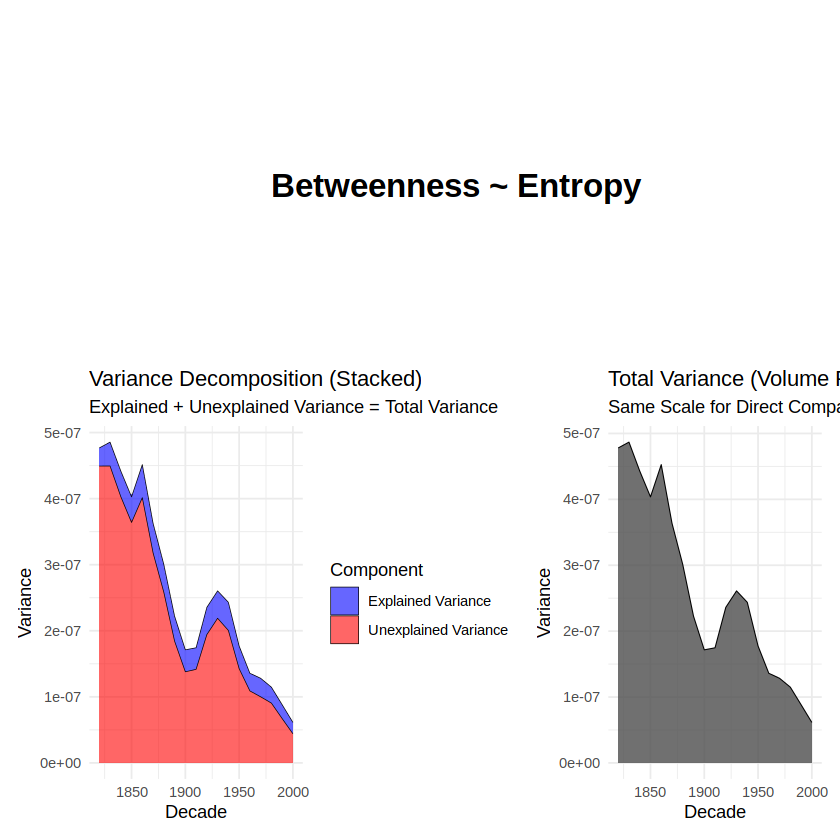

In [91]:
library(dplyr)
library(ggplot2)
library(patchwork)

# 1️⃣ Calculate variance decomposition by decade (Betweenness ~ Entropy)
variance_by_decade <- metrics_df_random %>%
  group_by(decade) %>%
  summarise(
    total_var = var(betweenness, na.rm = TRUE),
    explained_var = var(predict(lm(betweenness ~ entropy, data = cur_data())), na.rm = TRUE),
    unexplained_var = mean((betweenness - predict(lm(betweenness ~ entropy, data = cur_data())))^2, na.rm = TRUE),
    .groups = 'drop'
  )

# 2️⃣ Pivot longer for stacked area plot
variance_long <- variance_by_decade %>%
  select(decade, explained_var, unexplained_var) %>%
  tidyr::pivot_longer(
    cols = c(explained_var, unexplained_var),
    names_to = "Component",
    values_to = "Variance"
  )

# 3️⃣ Stacked area plot
p1 <- ggplot(variance_long, aes(x = decade, y = Variance, fill = Component)) +
  geom_area(alpha = 0.6, color = "black", size = 0.2) +
  labs(
    title = "Variance Decomposition (Stacked)",
    subtitle = "Explained + Unexplained Variance = Total Variance",
    x = "Decade",
    y = "Variance"
  ) +
  scale_fill_manual(
    values = c(
      "explained_var" = "blue",
      "unexplained_var" = "red"
    ),
    labels = c(
      "explained_var" = "Explained Variance",
      "unexplained_var" = "Unexplained Variance"
    )
  ) +
  theme_minimal()

# 4️⃣ Volume-style plot for total variance
p2 <- ggplot(variance_by_decade, aes(x = decade, y = total_var)) +
  geom_area(fill = "gray30", alpha = 0.8, color = "black", size = 0.3) +
  labs(
    title = "Total Variance (Volume Plot)",
    subtitle = "Same Scale for Direct Comparison",
    x = "Decade",
    y = "Variance"
  ) +
  ylim(0, max(variance_by_decade$total_var, na.rm = TRUE)) +
  theme_minimal()

# 5️⃣ Add label: "Betweenness ~ Entropy"
label_plot <- ggplot() +
  annotate(
    "text",
    x = 0.5, y = 0.5,
    label = "Betweenness ~ Entropy",
    size = 7, fontface = "bold"
  ) +
  theme_void()

# 6️⃣ Combine all
label_plot / (p1 + p2)


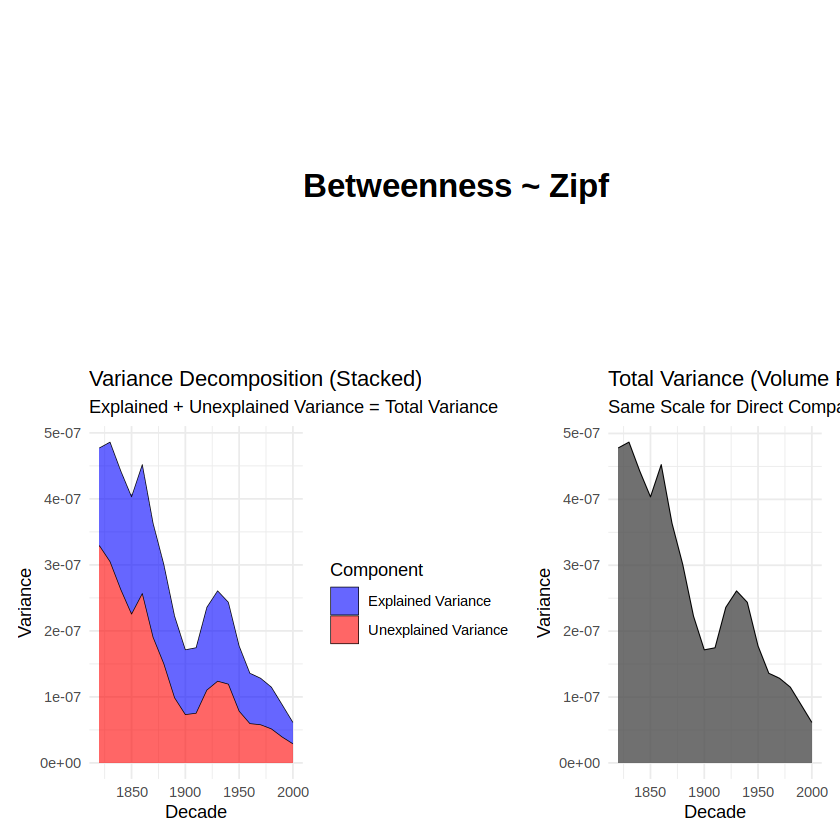

In [92]:
library(dplyr)
library(ggplot2)
library(patchwork)

# 1️⃣ Calculate variance decomposition by decade (Betweenness ~ Zipf)
variance_by_decade <- metrics_df_random %>%
  group_by(decade) %>%
  summarise(
    total_var = var(betweenness, na.rm = TRUE),
    explained_var = var(predict(lm(betweenness ~ zipf, data = cur_data())), na.rm = TRUE),
    unexplained_var = mean((betweenness - predict(lm(betweenness ~ zipf, data = cur_data())))^2, na.rm = TRUE),
    .groups = 'drop'
  )

# 2️⃣ Pivot longer for stacked area plot
variance_long <- variance_by_decade %>%
  select(decade, explained_var, unexplained_var) %>%
  tidyr::pivot_longer(
    cols = c(explained_var, unexplained_var),
    names_to = "Component",
    values_to = "Variance"
  )

# 3️⃣ Stacked area plot
p1 <- ggplot(variance_long, aes(x = decade, y = Variance, fill = Component)) +
  geom_area(alpha = 0.6, color = "black", size = 0.2) +
  labs(
    title = "Variance Decomposition (Stacked)",
    subtitle = "Explained + Unexplained Variance = Total Variance",
    x = "Decade",
    y = "Variance"
  ) +
  scale_fill_manual(
    values = c(
      "explained_var" = "blue",
      "unexplained_var" = "red"
    ),
    labels = c(
      "explained_var" = "Explained Variance",
      "unexplained_var" = "Unexplained Variance"
    )
  ) +
  theme_minimal()

# 4️⃣ Volume-style plot for total variance
p2 <- ggplot(variance_by_decade, aes(x = decade, y = total_var)) +
  geom_area(fill = "gray30", alpha = 0.8, color = "black", size = 0.3) +
  labs(
    title = "Total Variance (Volume Plot)",
    subtitle = "Same Scale for Direct Comparison",
    x = "Decade",
    y = "Variance"
  ) +
  ylim(0, max(variance_by_decade$total_var, na.rm = TRUE)) +
  theme_minimal()

# 5️⃣ Add label: "Betweenness ~ Zipf"
label_plot <- ggplot() +
  annotate(
    "text",
    x = 0.5, y = 0.5,
    label = "Betweenness ~ Zipf",
    size = 7, fontface = "bold"
  ) +
  theme_void()

# 6️⃣ Combine all
label_plot / (p1 + p2)
